In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import pandas as pd
import numpy as np

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.decoding import GeneralizingEstimator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

from scipy.stats import spearmanr

import multiprocess as mp
import dill
# Required for multiprocess to work in Jupyter notebook
dill.settings['recurse'] = True

from functools import partial

In [14]:
def get_perf_timecourse(X, y, decoder, perf_metric, n_splits=5):
    print(X.shape)
    classifying = len(np.unique(y)) <= 2

    n_times = X.shape[-1]

    scores = np.zeros(n_times)
    pvalues = np.zeros(n_times)

    kf = KFold(n_splits, shuffle=True)

    if classifying:
        kf = StratifiedKFold(n_splits, shuffle=True)

    max_acc = 0

    for t in range(n_times):
        t_scores = []
        t_pvalues = []

        for train_indices, test_indices in kf.split(X, y):
            decoder = decoder.fit(X[train_indices, :, t], y[train_indices])
            y_pred = decoder.predict(X[test_indices, :, t])

            if len(np.unique(y_pred)) > 1:
                score = perf_metric(y_pred, y[test_indices])
                acc = decoder.score(X[train_indices, :, t], y[train_indices])

                # if acc > max_acc:
                #     max_acc = acc
                #     print(acc)

                if classifying:
                    t_scores.append(score)
                    t_pvalues.append(0)
                else:
                    t_scores.append(score.statistic)
                    t_pvalues.append(score.pvalue)

        scores[t] = sum(t_scores) / len(t_scores)
        pvalues[t] = max(t_pvalues)

    return scores, pvalues


In [3]:
def as_df(x, y):
    return pd.DataFrame({'x': x, 'y': y})

In [4]:
def get_data(filename):
    fif = mne.read_epochs(f"./sub_data/{filename}")
    
    metadata = fif.metadata
    stim_features = metadata[["freq", "condition", "trial_type"]].to_numpy()

    sub_data = fif.get_data(picks=["meg"])
    
    del fif

    return stim_features, sub_data

In [5]:
# Useful constants for the rest of the code
sub_files = os.listdir("./sub_data")
n_subs = len(sub_files)

_, initial_sub_data = get_data(sub_files[0])
tpoints = initial_sub_data.shape[-1]

# Recordings were -200ms to 600ms, relative to the tone being played, collected at 161 points
t = np.linspace(-200, 600, tpoints)

# Helper function to get first index where condition is true
def index_of(cond):
    indices = np.where(cond)[0]
    
    if len(indices) == 0:
        return -1
    else:
        return indices[0]

# Helper for finding index of a particular point in time
def at_t(t_point):
    return index_of(t == t_point)

Reading C:\Users\isaac\Code\surp\sub_data\A0216_shepard-epo-lp20.fif ...


C:\Users\isaac\AppData\Local\Temp\ipykernel_29928\512867986.py:2: RuntimeWarning: This filename (./sub_data/A0216_shepard-epo-lp20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  fif = mne.read_epochs(f"./sub_data/{filename}")


    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
7645 matching events found
No baseline correction applied
0 projection items activated


In [40]:
fif = mne.read_epochs(f"./sub_data/{sub_files[0]}")

Reading C:\Users\isaac\Code\surp\sub_data\A0216_shepard-epo-lp20.fif ...


C:\Users\isaac\AppData\Local\Temp\ipykernel_29928\553458094.py:1: RuntimeWarning: This filename (./sub_data/A0216_shepard-epo-lp20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  fif = mne.read_epochs(f"./sub_data/{sub_files[0]}")


    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
7645 matching events found
No baseline correction applied
0 projection items activated


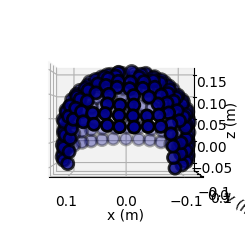

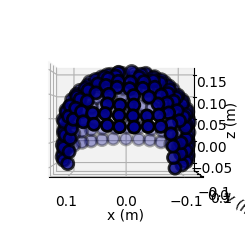

In [7]:
fig = plt.figure()
ax3d = fig.add_subplot(122, projection="3d")
fif.plot_sensors(ch_type="mag", axes=ax3d, kind="3d")

In [37]:
sensor_locations = np.zeros((len(fif.info["chs"]), 3))

for i, ch in enumerate(fif.info["chs"]):
    sensor_locations[i] = ch['loc'][:3]
    
right_idx = sensor_locations[:,0] >= 0
left_idx = sensor_locations[:,0] <= 0

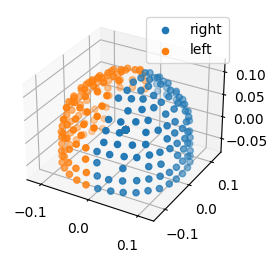

In [22]:
fig = plt.figure()
ax3d = fig.add_subplot(122, projection="3d")

right_sensors = sensor_locations[right_idx]
left_sensors = sensor_locations[left_idx]

ax3d.scatter(*right_sensors.T, label="right")
ax3d.scatter(*left_sensors.T, label="left")
ax3d.legend()
plt.show()

In [9]:
filters = {
    "pure": lambda features: (features[:,1] == "pure"),
    "complex": lambda features: (features[:,1] == "partial"),
    "ambiguous": lambda features: (features[:,1] == "shepard")
}

def get_sub_scores(filename):    
    stim_features, sub_data = get_data(filename)
    
    ridge_decoder = make_pipeline(
        StandardScaler(),
        Ridge()
    )
    
    freqs = stim_features[:, 0]

    sub_scores = { }
    
    for condition in filters:
        condition_filter = filters[condition](stim_features)

        print(sub_data.shape)
        print(f"Finding {condition} scores for {filename}...", end="\r")
        condition_scores, _ = get_perf_timecourse(sub_data[condition_filter, left_idx], freqs[condition_filter], ridge_decoder, spearmanr)
        
        sub_scores[condition] = condition_scores
    
    del freqs, sub_data, stim_features

    return sub_scores
    
def get_gen_scores(filename):
    stim_features, sub_data = get_data(filename)
    freqs = stim_features[:, 0]

    ridge_decoder = make_pipeline(
        StandardScaler(),
        Ridge()
    )

    for condition in filters:
        condition_filter = filters[condition](stim_features)

        print(f"Finding generalized {condition} scores for {filename}...", end="\r")
        spearman_scorer = make_scorer(spearmanr, greater_is_better=True)
        
        time_gen = GeneralizingEstimator(ridge_decoder, scoring=spearman_scorer, n_jobs=-1)
        time_gen.fit(X=sub_data[condition_filter], y=freqs[condition_filter])
        output = time_gen.score(X=sub_data[condition_filter], y=freqs[condition_filter])
        
        first_elem = lambda tup: tup[0]
        first_elem_vectorized = np.vectorize(first_elem)
        sub_scores_gen = first_elem_vectorized(output)
        
MERGED_SCORES_LOCATION = "merged_scores.npy"

def save_merged_scores(merged_scores):
    np.save(MERGED_SCORES_LOCATION, merged_scores)

def load_merged_scores():
    empty = not os.path.isfile(MERGED_SCORES_LOCATION)
    merged_sub_scores = {
        "pure": np.zeros((n_subs, tpoints)),
        "complex": np.zeros((n_subs, tpoints)),
        "ambiguous": np.zeros((n_subs, tpoints)),
    }
    
    if not empty:
        try:
            merged_sub_scores = np.load("merged_scores_left.npy", allow_pickle=True).item()
        except Exception:
            empty = True
            return merged_sub_scores, empty
    
    return merged_sub_scores, empty

In [13]:
get_sub_scores(sub_files[0])

Reading C:\Users\isaac\Code\surp\sub_data\A0216_shepard-epo-lp20.fif ...


C:\Users\isaac\AppData\Local\Temp\ipykernel_29928\512867986.py:2: RuntimeWarning: This filename (./sub_data/A0216_shepard-epo-lp20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  fif = mne.read_epochs(f"./sub_data/{filename}")


    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
7645 matching events found
No baseline correction applied
0 projection items activated
(7645, 208, 161)
(2160, 208, 161)res for A0216_shepard-epo-lp20.fif...


KeyboardInterrupt: 

In [2]:
merged_sub_scores, empty = load_merged_scores()

# If merged scores have not already been saved, generate them (this takes a long time)
if empty:
    output = None

    try:
        pool = mp.Pool(8)
        output = pool.map(partial(get_sub_scores), sub_files)
    except KeyboardInterrupt as e:
        pass
    finally:
        pool.terminate()
        pool.join()

    merged_sub_scores = {
        "pure": np.zeros((n_subs, tpoints)),
        "complex": np.zeros((n_subs, tpoints)),
        "ambiguous": np.zeros((n_subs, tpoints)),
    }

    for i in range(n_subs):
        for condition in filters:
            merged_sub_scores[condition][i] = output[i][condition]

    save_merged_scores(merged_sub_scores)

NameError: name 'os' is not defined

## Heterogeneity Analysis

Ideas
* Butterfly plot
* Distributions of particular metrics
    * Score at particular time points - e.g. around the first peak (~75ms) and second (~500ms)
    * Scores around those time points
        * Mean
        * Max
    * Joint distribution of scores at the first and second peaks
    * Times at which max values occured
* Clustering analysis
    * t-SNE
    * Spectral
    * k-means
* Dimensionality reduction
    * LFA
    * umap
    * PCA

In [28]:
# Condition to be used for further analysis
CONDITION = "pure"
scores = merged_sub_scores[CONDITION]

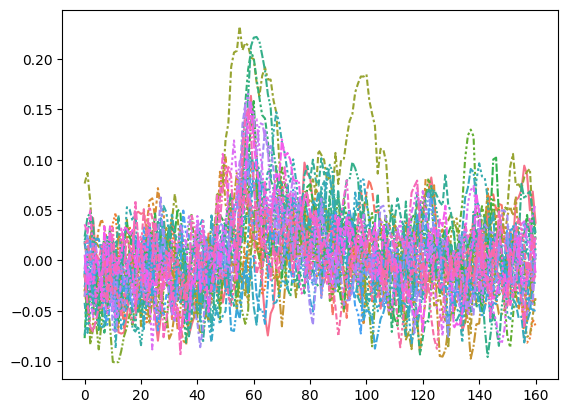

In [36]:
sns.lineplot(scores.T)
plt.legend([],[], frameon=False)

<Axes: >

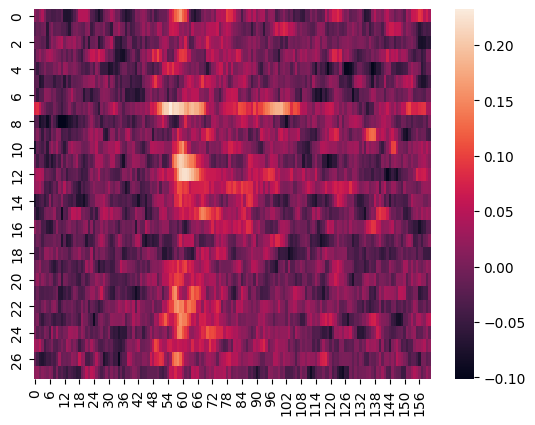

In [37]:
sns.heatmap(scores)

<Axes: ylabel='Count'>

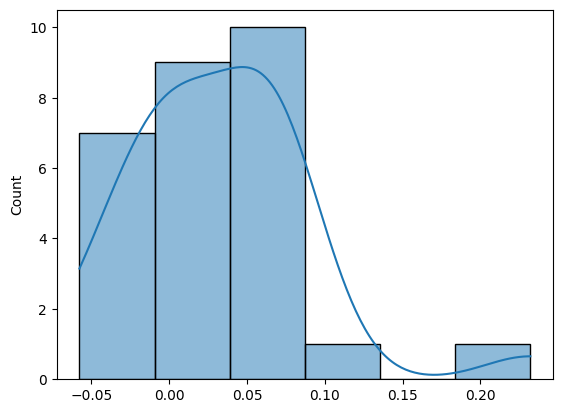

In [38]:
scores_at_t = scores[:, at_t(75)]
sns.histplot(scores_at_t, kde=True)

<Axes: ylabel='Count'>

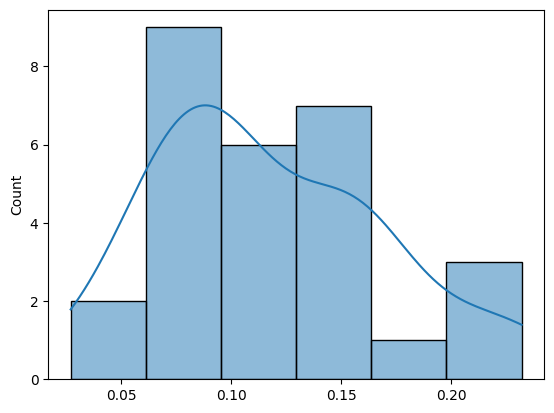

In [39]:
max_scores = scores[:,at_t(50):at_t(150)].max(axis=-1)
sns.histplot(max_scores, kde=True)

<Axes: ylabel='Count'>

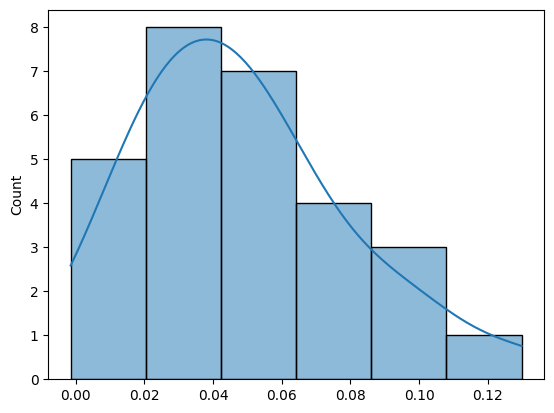

In [40]:
max_scores = scores[:,at_t(450):at_t(550)].max(axis=-1)
sns.histplot(max_scores, kde=True)

In [41]:
# Between-subject z-scores
btw_mean = scores.mean()
btw_std = scores.std()

btw_sub_z = (scores - btw_mean) / btw_std

# Within-subject z-scores
wtn_mean = scores.mean(axis=-1)
wtn_std = scores.std(axis=-1)

wtn_sub_z = ((scores.T - wtn_mean) / wtn_std).T

<Axes: ylabel='Count'>

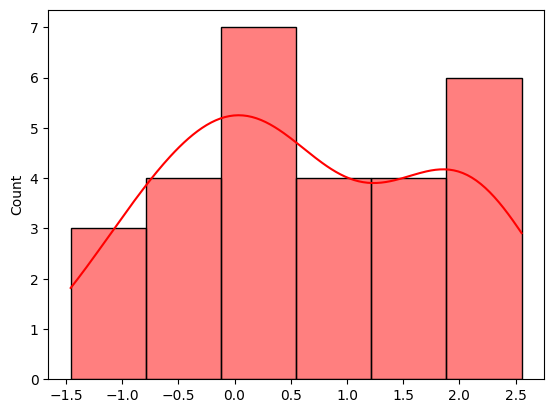

In [42]:
# Find distributions wrt z-scores
scores_at_t = wtn_sub_z[:, at_t(75)]
sns.histplot(scores_at_t, kde=True, color="red")

<Axes: ylabel='Count'>

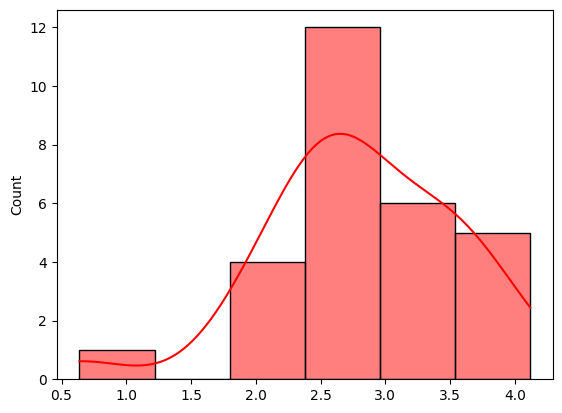

In [46]:
max_scores_early = wtn_sub_z[:,at_t(50):at_t(150)].max(axis=-1)
sns.histplot(max_scores_early, kde=True, color="red")

<Axes: ylabel='Count'>

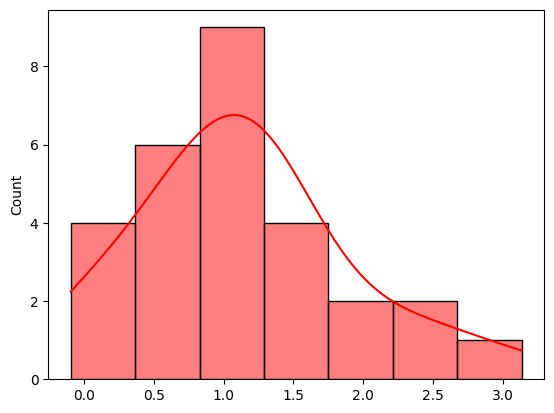

In [51]:
max_scores_late = wtn_sub_z[:,at_t(450):at_t(550)].max(axis=-1)
sns.histplot(max_scores_late, kde=True, color="red")

In [53]:
max_scores_late[max_scores_late > 1].shape[0]/max_scores_late.shape[0]

0.5714285714285714

<Axes: xlabel='early', ylabel='late'>

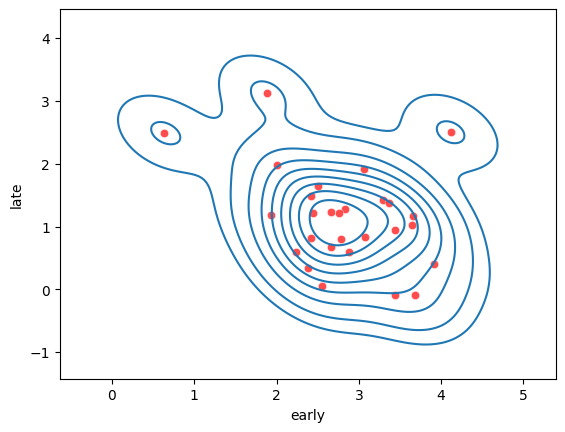

In [50]:
#max_scores_joint = np.stack([max_scores_early, max_scores_late], axis=-1)
max_scores_joint = {"early": max_scores_early, "late": max_scores_late}
sns.scatterplot(max_scores_joint, x="early", y="late", alpha=0.7, color="red")

sns.kdeplot(max_scores_joint, x="early", y="late")

<Axes: >

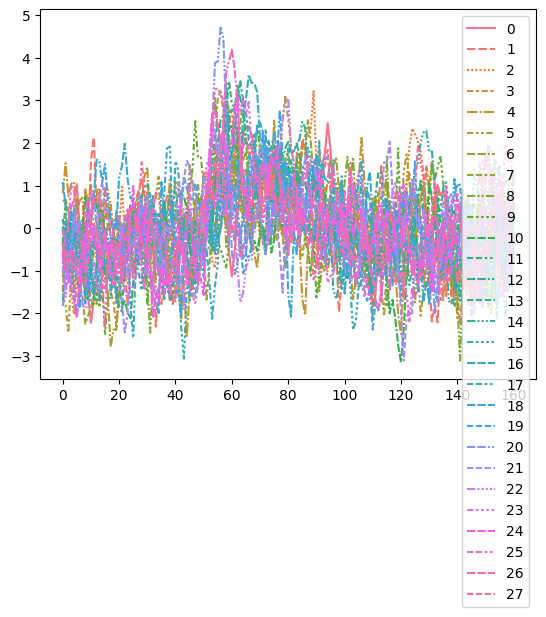

In [97]:
sns.lineplot(wtn_sub_z.T)

In [68]:
scores.std(axis=-1).mean()

0.03927717021627678

<Axes: ylabel='Count'>

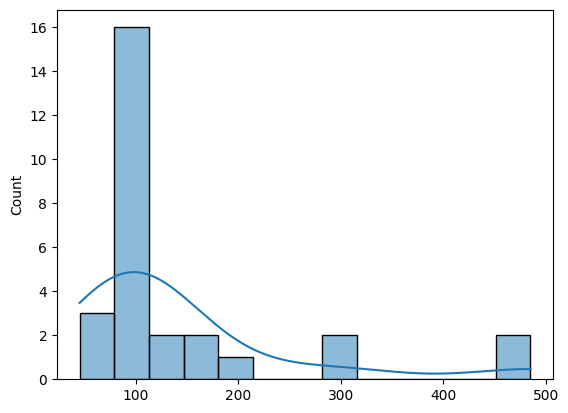

In [65]:
max_ts = np.argmax(scores, axis=-1)
max_t_vals = t[max_ts]
sns.histplot(max_t_vals, kde=True, discrete=False)

* Plot timecourses as matrix
* Plot peak time vs peak value
* PCA -- see how fast the loadings drop off
* Clustering

<Axes: xlabel='t', ylabel='score'>

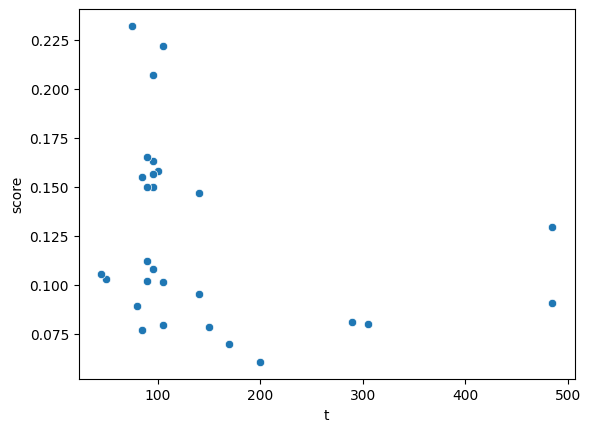

In [64]:
max_scores = np.max(scores, axis=-1)
max_joint = {"t": max_t_vals, "score": max_scores}
sns.scatterplot(max_joint, x="t", y="score")

<Axes: >

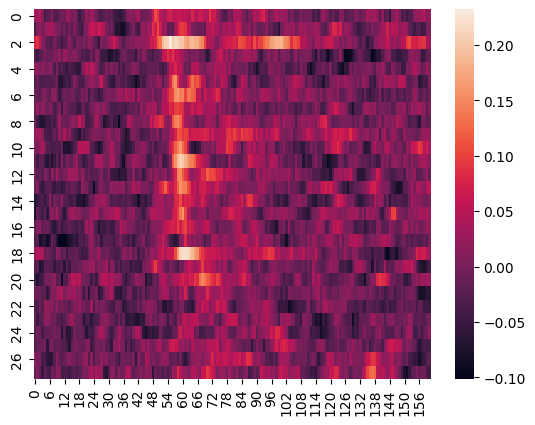

In [23]:
sorted_scores = scores[np.argsort(max_ts)]
sns.heatmap(sorted_scores)

Observations
* At rows 2 and 18, the subjects have 2 defined peaks around the same times, which isn't seen in the other subjects
* The subjects at rows 0-2 and 8 have peaks that start notably earlier than any others
* Most subjects seem to have a single peak somewhere around 100ms
* A few subjects have later peaks, and a couple (last 2 rows) are most decodable at those peaks
* Many of the subjects have noisy signals that appear to represent very little decodable information (rows 21-24)

<Axes: >

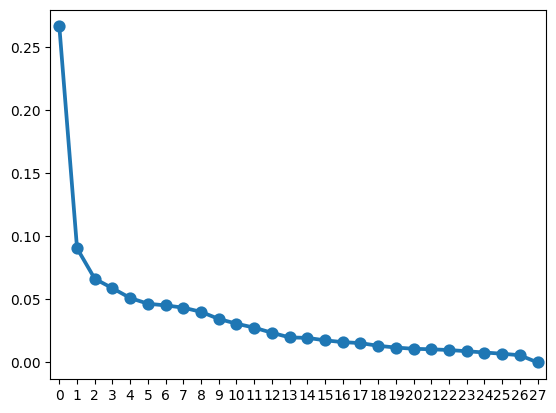

In [56]:
pca = PCA()
transformed_scores = pca.fit_transform(scores)
sns.pointplot(pca.explained_variance_ratio_)

<Axes: xlabel='PC 1', ylabel='PC 2'>

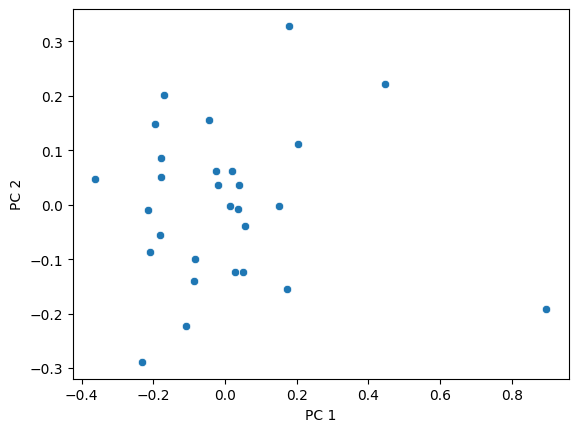

In [57]:
sns.scatterplot({"PC 1": transformed_scores[:,0], "PC 2": transformed_scores[:,1]}, x="PC 1", y="PC 2")

<Axes: xlabel='Dimension 1', ylabel='Dimension 2'>

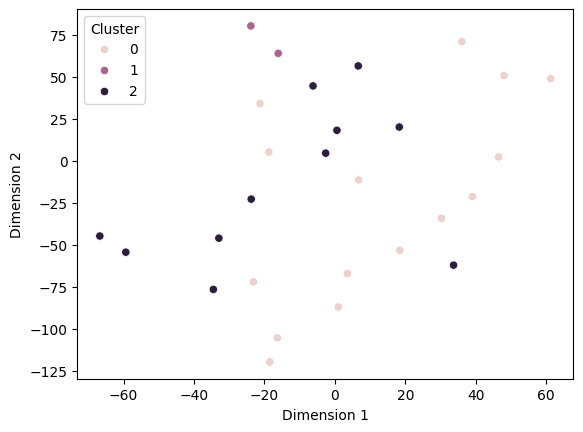

In [59]:
n_clusters = 3
spc = SpectralClustering(n_clusters=n_clusters)
clusters = spc.fit_predict(scores)

tsne = TSNE(perplexity=5, n_components=2)
tsne_transformed_scores = tsne.fit_transform(scores)

tsne_df = pd.DataFrame(tsne_transformed_scores[:,:2], columns=["Dimension 1", "Dimension 2"])
tsne_df["Cluster"] = clusters
sns.scatterplot(tsne_df, x="Dimension 1", y="Dimension 2", hue="Cluster")

<Axes: >

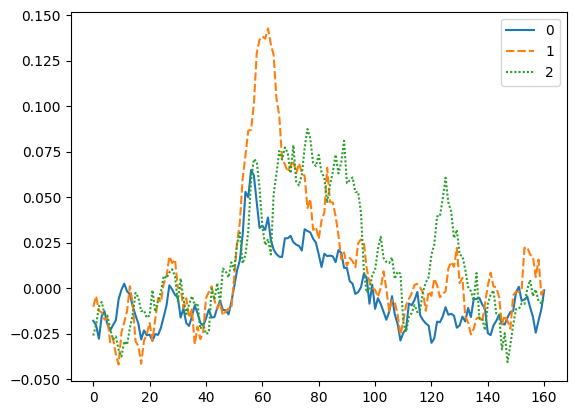

In [104]:
sns.lineplot([scores[clusters == i].mean(axis=0) for i in range(n_clusters)])

<Axes: >

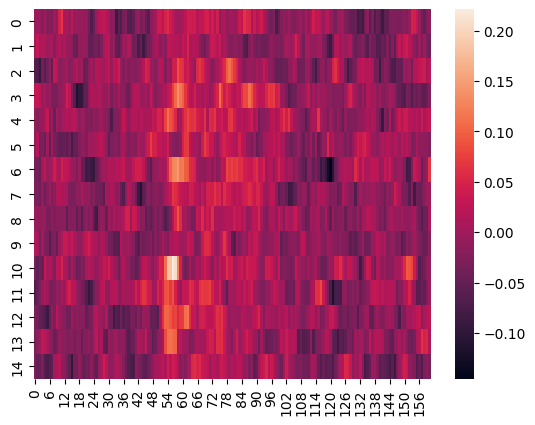

In [105]:
sns.heatmap(scores[clusters == 0])

<Axes: >

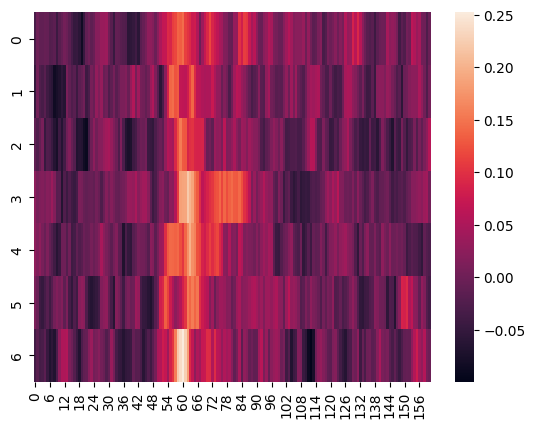

In [106]:
sns.heatmap(scores[clusters == 1])

<Axes: >

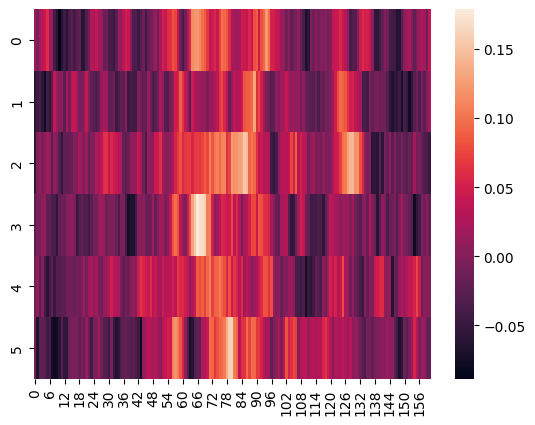

In [107]:
sns.heatmap(scores[clusters == 2])

<Axes: >

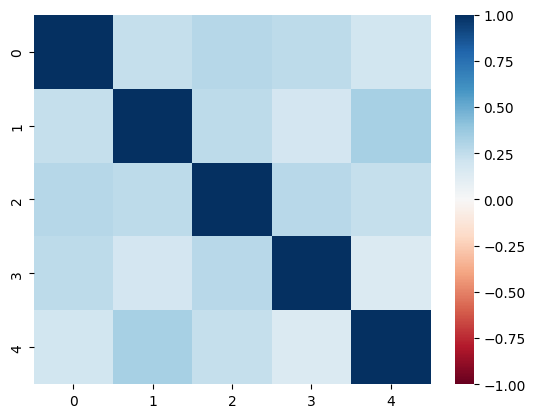

In [56]:
cluster_corrs = np.corrcoef(scores[clusters == 2])
sns.heatmap(cluster_corrs, vmin=-1, vmax=1, cmap="RdBu")

This clustering approach doesn't really seem to be grouping by important functional features (e.g. peaks), are there embeddings that would better represent said features?

How about a regression of the form:
$$
s_t=Z_t+L(t)+\sum_{n}K_n(t)
$$
where $Z_t$ is white noise, $L(t)$ is a monotonic function (logistic or linear) \[may or may not be needed\] and $K_n(t)$ are kernel functions (e.g. gaussian) representing each peak

How can this be embedded in a functional space?

One method is to assuume there are a fixed number $N$ of kernels to be used, then make the parameters of each (+ the parameters of $L(t)$) dimensions in the space, ordered by something like where each kernel is centered
However, this causes some problems. Firstly, each kernel would probably have at least three parameters (centroid, spread, amplitude), so we'd end up with an $(N+1)\times 3$ matrix representing each curve. This could, of course, be flattened, but even then we run into another issue: Kernel ordering. Each kernel represents a separate dimension in this functional space, but assigning dimensions simply based on the ordering of kernels doesn't make much sense. For instance, let's say one signal has a single peak around 100ms and another has one of the same size and shape at 400ms. Since both have only a single peak, they would show up as identical (assuming $L(t)$ is the same for both) in the functional space if a Euclidean metric is used, even though they're entirely different signals. Conversely, two signals with peaks in the same places, but a different number of peaks (maybe the first has a small intermittent peak), could be rendered completely different. One way to solve this would be to anchor the kernels at a discrete set of centroids, but what if these don't quite line up with the peaks in the data? Another would be to transform the signals to a continuous functional space. I'll elaborate on this in the next paragraph. A final solution could be changing the metric in some way that accounts for centroid location.

A second option is to map signals to a continuous functional space, essentially doing a "kernel transform" and somehow incorporating the linear term as well. However, I'm not sure how well this would work when kernel locations are slightly shifted, especially if a Euclidean-like metric is used.

What about other metrics?

<Axes: >

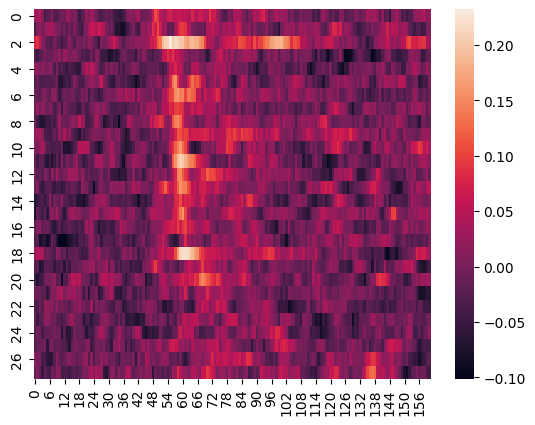

In [24]:
sns.heatmap(sorted_scores)

<Axes: >

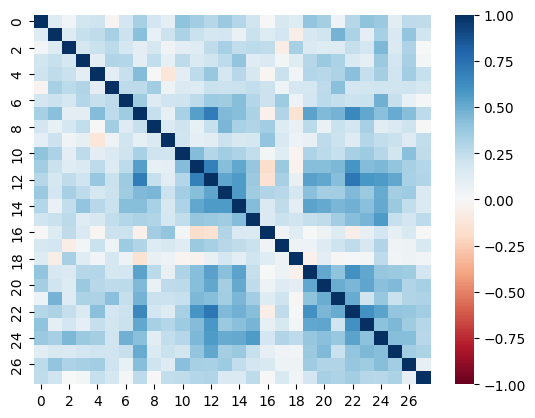

In [25]:
corrs = np.corrcoef(scores)
sns.heatmap(corrs, cmap="RdBu", vmin=-1, vmax=1)

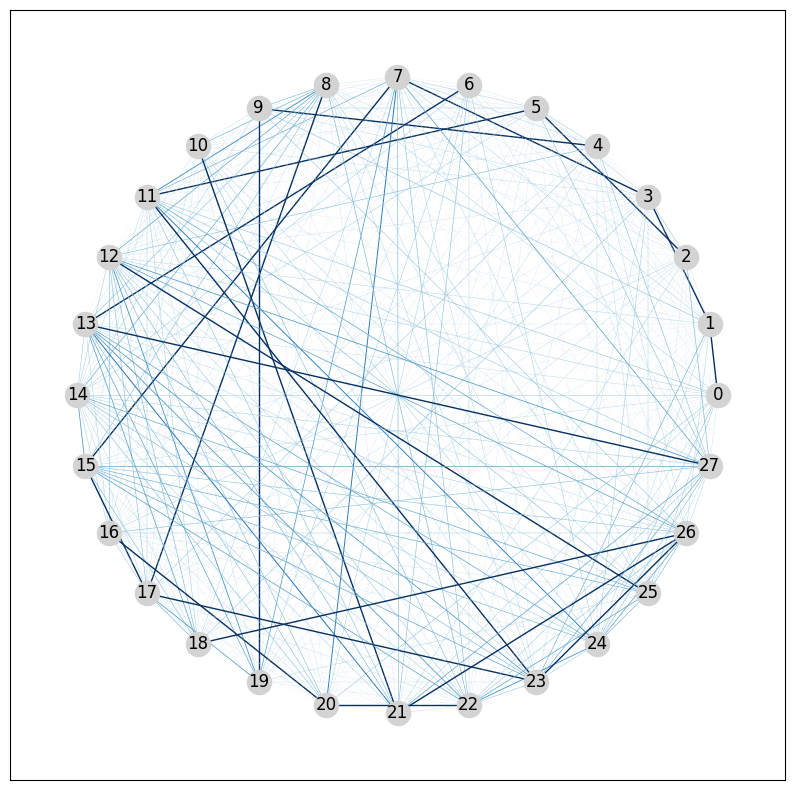

In [26]:
import networkx as nx
from networkx.algorithms.community import girvan_newman, asyn_fluidc, louvain_communities
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def draw_graph(graph, ax):
    # Make a copy so that edge removal does not persist
    plot_graph = graph.copy()
    pos = nx.circular_layout(plot_graph)
    weights = [corr_graph[u][v]['weight'] for u,v in plot_graph.edges()]
    plot_graph.remove_edges_from(nx.selfloop_edges(plot_graph))

    cmap = cm.RdBu
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    edge_colors = [cmap(norm(weight)) for weight in weights]

    nx.draw_networkx(
        plot_graph, 
        pos=pos,
        width=weights,
        edge_color=edge_colors,
        node_color="lightgrey",
        ax=ax
    )
    
corr_graph = nx.from_numpy_array(corrs)
fig, ax = plt.subplots(figsize=(10,10))
draw_graph(corr_graph, ax)

In [31]:
communities = louvain_communities(corr_graph, weight='weight', resolution=1)

cluster_assignments = np.zeros(n_subs)
community_nodes = []
for i, community in enumerate(communities):
    community_nodes.append(community)
    community_indices = np.array(list(community))
    cluster_assignments[community_indices] = i
    
cluster_assignments

array([4., 0., 7., 0., 2., 0., 6., 5., 3., 3., 4., 5., 5., 3., 1., 7., 3.,
       6., 7., 5., 5., 0., 5., 5., 7., 5., 4., 2.])

C:\Users\isaac\AppData\Local\Temp\ipykernel_12520\2854282394.py:14: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(cluster_scores.T, ax=axs[cluster, 2], palette=['black'])
C:\Users\isaac\AppData\Local\Temp\ipykernel_12520\2854282394.py:14: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(cluster_scores.T, ax=axs[cluster, 2], palette=['black'])
C:\Users\isaac\AppData\Local\Temp\ipykernel_12520\2854282394.py:14: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(cluster_scores.T, ax=axs[cluster, 2], palette=['black'])
C:\Users\isaac\AppData\Local\Temp\ipykernel_12520\2854282394.py:14: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sn

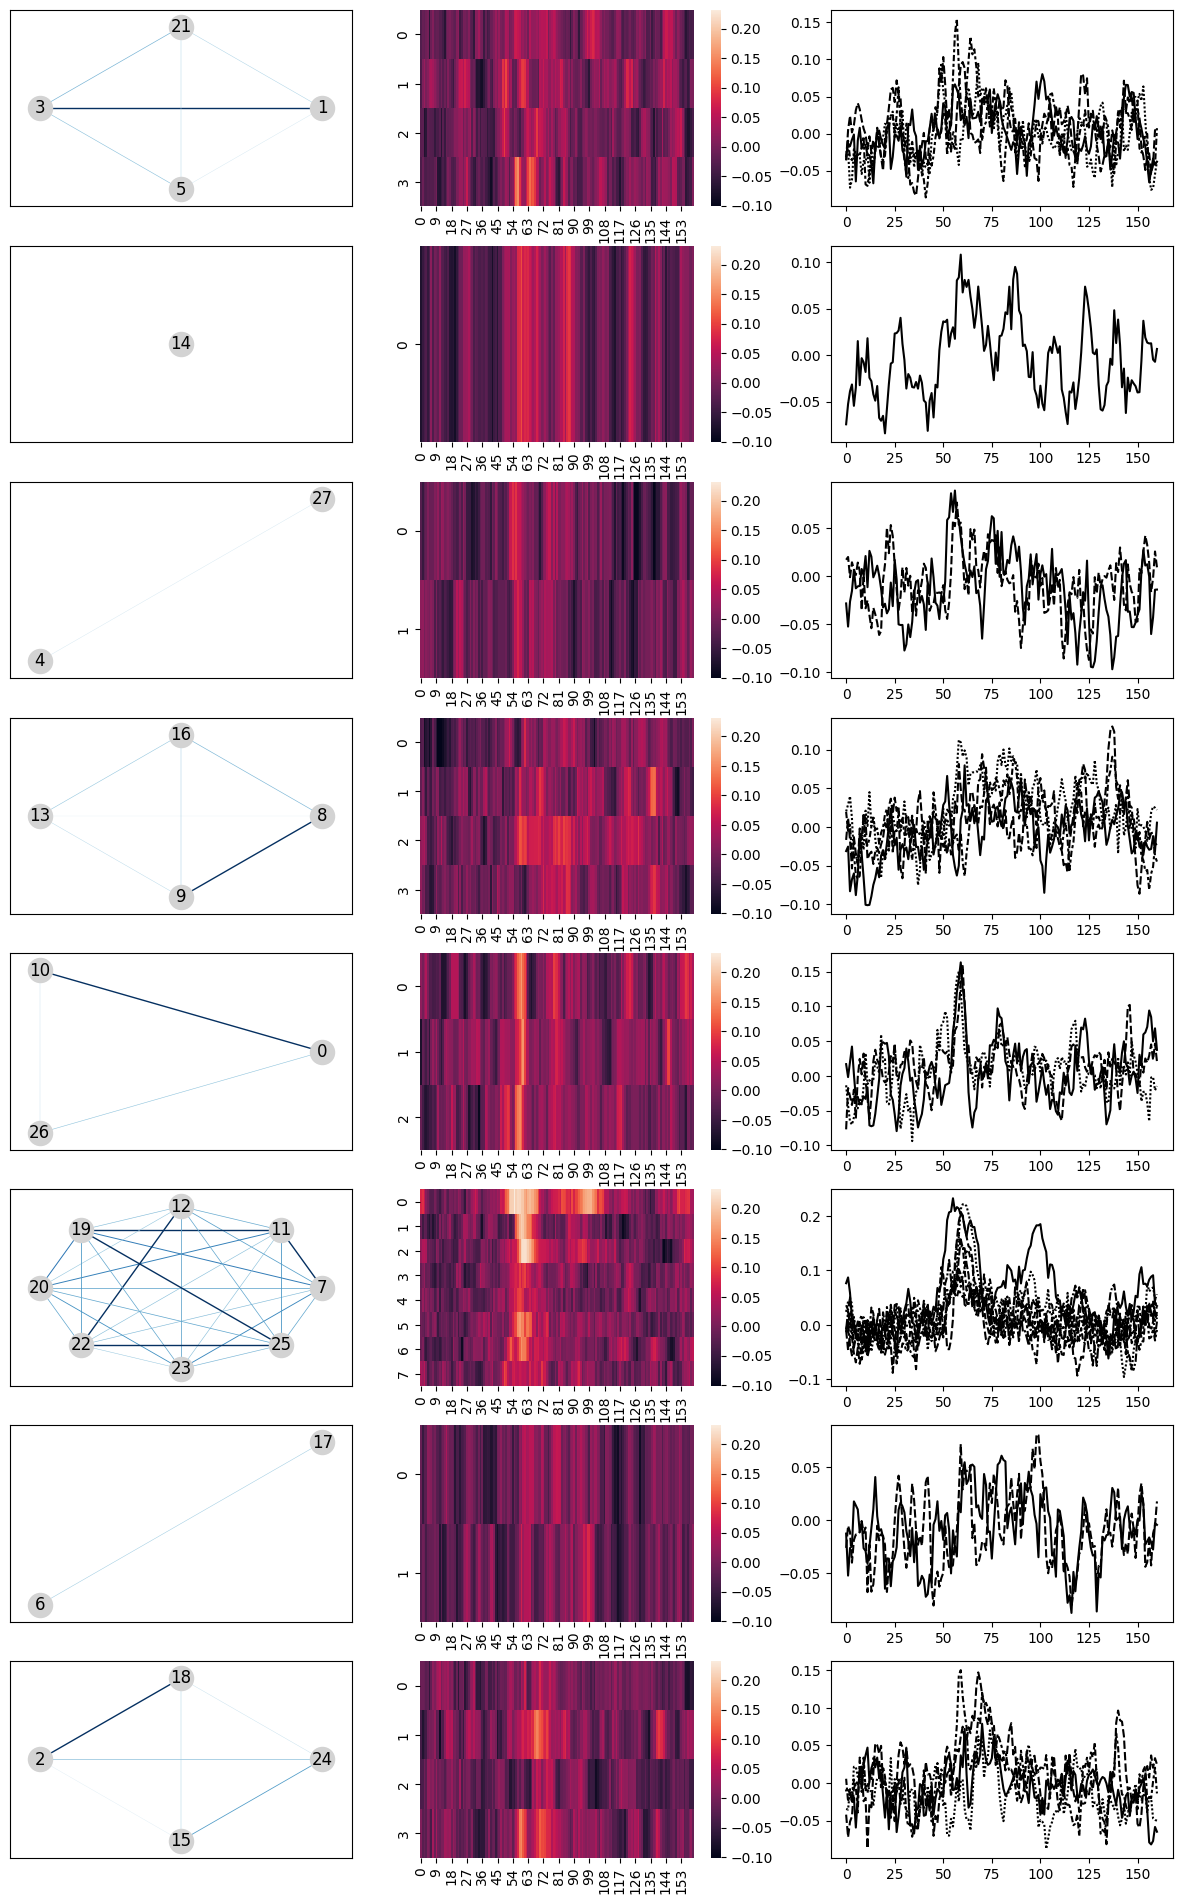

In [33]:
clusters = np.unique(cluster_assignments).astype(int)
max_size = max([scores[cluster_assignments == cluster].shape[0] for cluster in clusters])

fig, axs = plt.subplots(ncols=3, nrows=len(clusters), figsize=(15,3*clusters.shape[0]))

for cluster in clusters:
    cluster_scores = scores[cluster_assignments == cluster]
    community = community_nodes[cluster]
    
    padding = 0#max_size - cluster_scores.shape[0]
    padded_cluster_scores = np.pad(cluster_scores, ((0, padding), (0, 0)))
    
    sns.heatmap(padded_cluster_scores, ax=axs[cluster, 1], vmax=scores.max(), vmin=scores.min())
    sns.lineplot(cluster_scores.T, ax=axs[cluster, 2], palette=['black'])

    #sns.heatmap(np.corrcoef(cluster_scores), ax=axs[cluster, 0], cmap="RdBu", vmin=-1, vmax=1)
    draw_graph(corr_graph.subgraph(community), ax=axs[cluster, 0])
    
    
    axs[cluster, 1].legend([],[], frameon=False)
    axs[cluster, 2].legend([],[], frameon=False)

Using Louvain community detection seems rather arbitrary and gives variable results, although I think it's the only community detection algorithm that `networkx` has for weighted graphs. Standard correlation clustering might give more robust results

Heirarchical clustering seems to be the most popular way to do this, but I don't think heirarchies will be very useful for this dataset. Still could help to illuminate potential clusters though

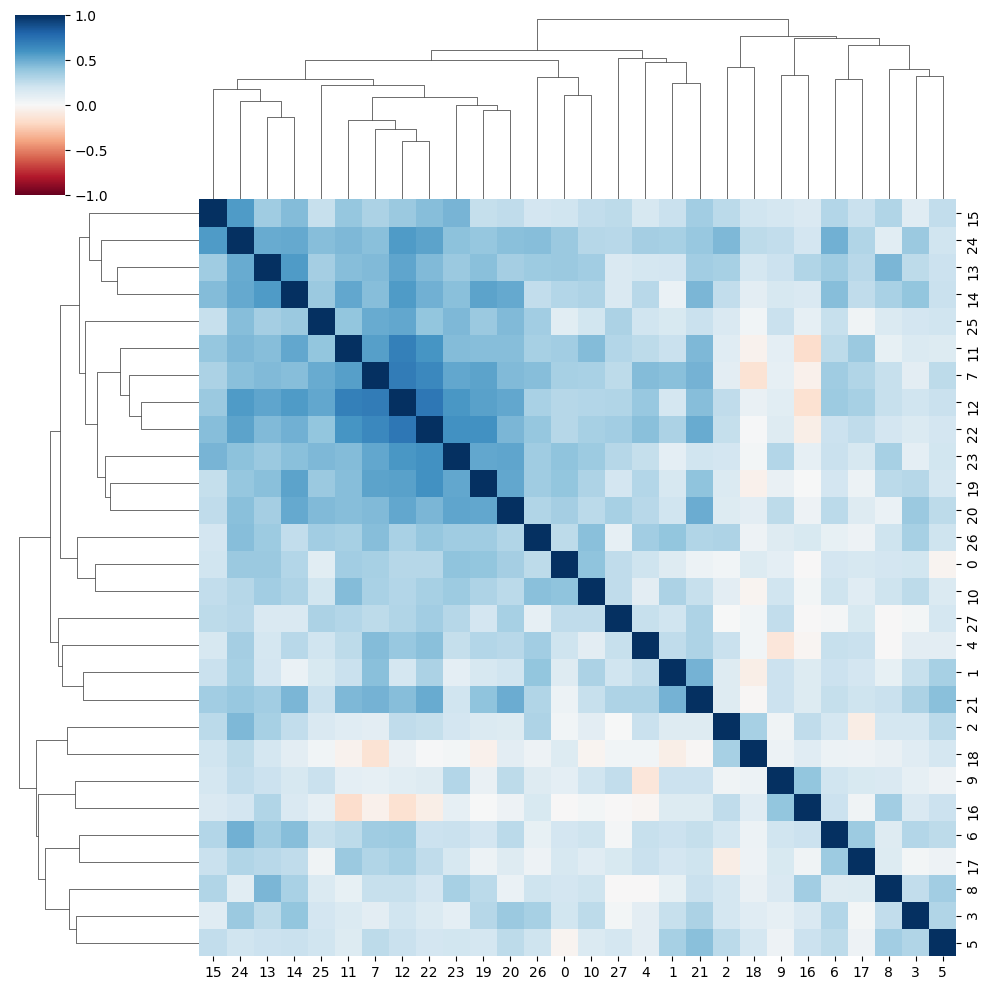

In [30]:
sns.clustermap(corrs, cmap="RdBu", vmin=-1, vmax=1)

Q: How do we statistically test for the existence of clusters?

^ The result above doesn't seem very promising and I'm wondering how I could test whether the correlation groupings are in fact random

Unfortunately it seems there's no pre-implemented algorithm in Python for non-heirarchical (weighted) correlation clustering, so I may not be able to do this at the moment. There was one github library [here](https://github.com/Garrafao/correlation_clustering) but I end up with a bunch of errors when I try to run it on my machine

Why would performance be below chance? Is that guaranteed to be random noise? If so, could we use the below-chance fluctuations as a model for what noise should look like?

# t-clustering

In [30]:
t_obs, clusters, cluster_pvs, H0 = mne.stats.permutation_cluster_1samp_test(scores, threshold=1.96)

stat_fun(H1): min=-4.726599 max=6.853806
Running initial clustering …
Found 12 clusters


c:\users\isaac\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████| Permuting : 1023/1023 [00:00<00:00, 2070.63it/s]


<Axes: >

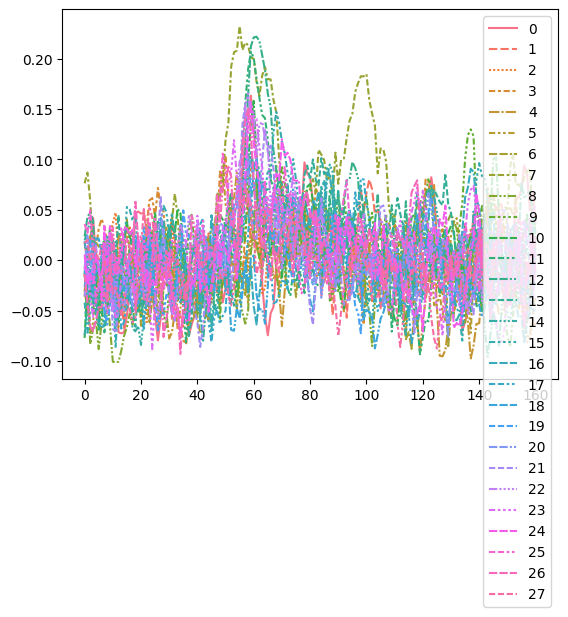

In [33]:
sns.lineplot(scores.T)

0.0009765625
0.0048828125
0.013671875


Text(0, 0.5, 'Spearman correlation')

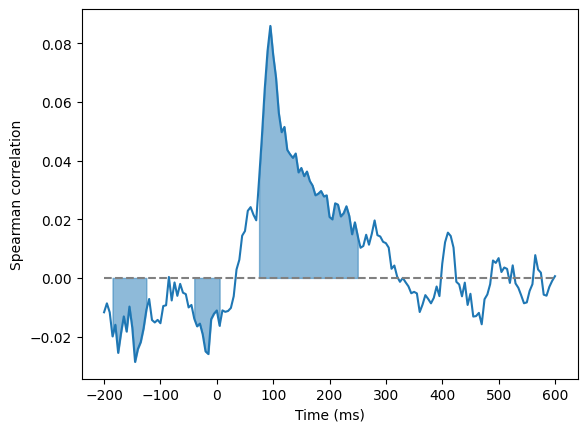

In [32]:
fig, ax = plt.subplots()

avg_scores = scores.mean(axis=0)
alpha = 0.05

for cluster, pv in zip(clusters, cluster_pvs):
    if pv < alpha: 
        print(pv)
        ax.fill_between(t[cluster], avg_scores[cluster], color="tab:blue", alpha=0.5)
    
sns.lineplot(as_df(t, avg_scores), x='x', y='y', color="tab:blue", ax=ax)
sns.lineplot(as_df(t, 0), x='x', y='y', color="gray", linestyle="dashed", ax=ax)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Spearman correlation")

What sort of individual differences are we looking for?

# Temporal Generalization

In [ ]:
decoder = make_pipeline(
    StandardScaler(),
    Ridge()
)

spearman_scorer = make_scorer(spearmanr, greater_is_better=True)
time_gen = GeneralizingEstimator(decoder, scoring=spearman_scorer, n_jobs=None)
time_gen.fit(X=sub_data[pure], y=freqs[pure])
output = time_gen.score(X=sub_data[pure], y=freqs[pure])

first_elem = lambda tup: tup[0]
first_elem_vectorized = np.vectorize(first_elem)
scores = first_elem_vectorized(output)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:04<00:00,   32.70it/s]
 55%|███████████████████████▏                  | Scoring GeneralizingEstimator : 14317/25921 [11:09<08:56,   21.61it/s]

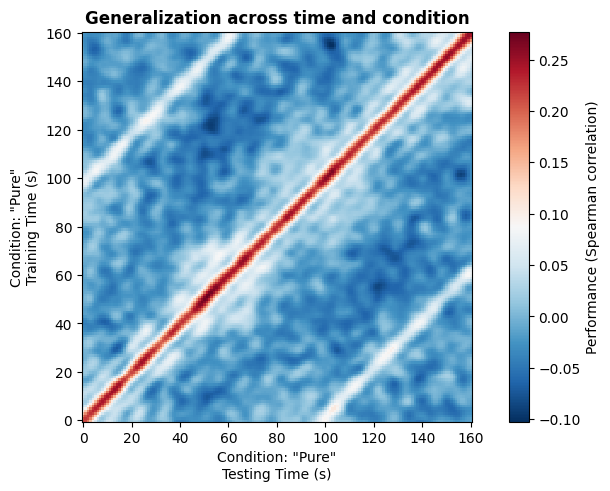

In [15]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    avg_scores_gen["ambiguous"],
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure"\nTraining Time (s)')
ax.set_title("Generalization across time and condition", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

logistic_decoder = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

features_pc = stim_features[pure | complx,1] == "pure"
input_pc = sub_data[pure | complx]
score_pc, _ = get_perf_timecourse(input_pc, features_pc, logistic_decoder, roc_auc_score)

features_pa = stim_features[pure | ambiguous,1] == "pure"
input_pa = sub_data[pure | ambiguous]
score_pa, _ = get_perf_timecourse(input_pa, features_pa, logistic_decoder, roc_auc_score)

features_ca = stim_features[complx | ambiguous,1] == "partial"
input_ca = sub_data[complx | ambiguous]
score_ca, _ = get_perf_timecourse(input_ca, features_ca, logistic_decoder, roc_auc_score)

In [ ]:
plt.plot(t, score_pc, label="Pure vs. Complex")
plt.plot(t, score_pa, label="Pure vs. Ambiguous")
plt.plot(t, score_ca, label="Complex vs. Ambiguous")
plt.plot(t, 0.5 * np.ones_like(t), linestyle="--", color="gray")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("ROC AUC Score")
plt.ylim([0,1])

In [ ]:
t0 = 40

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

kf = StratifiedKFold(5, shuffle=True)
X = input_pc[:,:,t0]
y = features_pc

for train, test in kf.split(X, y):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)x
    s = roc_auc_score(y_pred, y_test)
    print("AUC:", s)

Text(0.5, 1.0, 't=35.0ms')

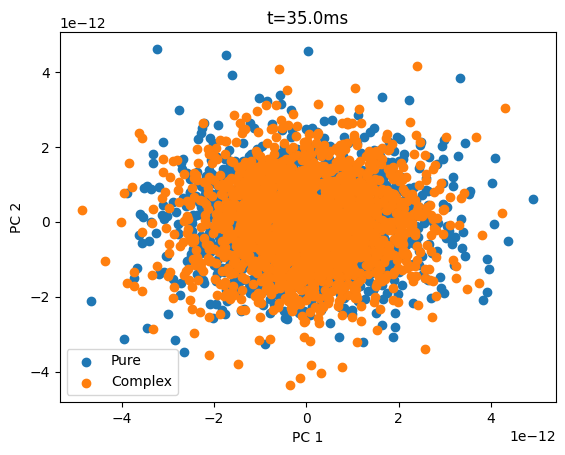

In [40]:
t0 = 47

pca = PCA(n_components=2, svd_solver="full")
transformed = pca.fit_transform(input_pc[:,:,t0])

transformed_pure = transformed[features_pc]
transformed_complx = transformed[~features_pc]

plt.scatter(transformed_pure[:,0], transformed_pure[:,1], label="Pure")
plt.scatter(transformed_complx[:,0], transformed_complx[:,1], label="Complex")
plt.legend()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"t={t[t0]}ms")

In [18]:
c = 0
loadings = pca.components_[c].copy()
n_top = 3
top_loadings = []

for i in range(n_top):
    max_idx = np.argmax(loadings)
    top_loadings.append((max_idx, loadings[max_idx]))
    loadings[max_idx] = 0
    
top_loadings

[(137, 0.20615029457880427),
 (121, 0.1937262323574115),
 (136, 0.16945149240978483)]

In [38]:
time_gen = GeneralizingEstimator(logistic_decoder, scoring="roc_auc", n_jobs=None)
time_gen.fit(X=input_pc, y=features_pc)
scores_gen_pc = time_gen.score(X=input_pc, y=features_pc)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:36<00:00,    4.40it/s]
100%|██████████████████████████████████████████| Scoring GeneralizingEstimator : 25921/25921 [14:39<00:00,   29.47it/s]


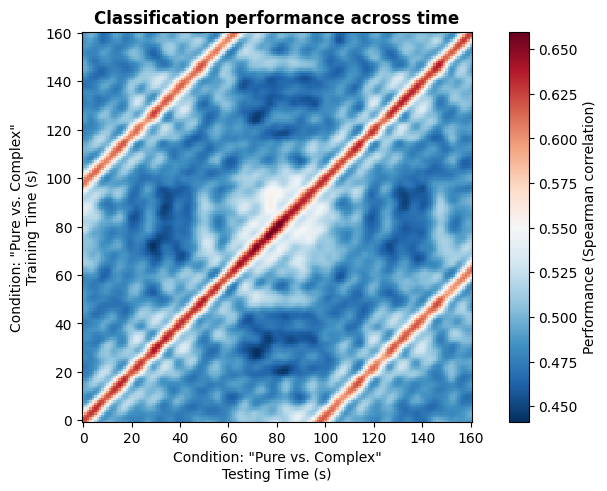

In [39]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores_gen_pc,
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure vs. Complex"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure vs. Complex"\nTraining Time (s)')
ax.set_title("Classification performance across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()